In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

In [2]:
device = torch.device("cuda:0")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
torch.set_default_tensor_type('torch.cuda.FloatTensor')

True
Tesla T4


# Ridge Regression

Only using one sigma here because we've seen the effect of noise

In [39]:
sigma1 = 0.5 #SNR = 4
sigma2 = 1 #SNR = 1
sigma3 = 0.1

sigmas = [sigma1,sigma2,sigma3]

lambdas = torch.tensor([1e-6,1e-4,1e-2,1e-1,1,10])

We will have to use cross-validation to pick the optimal lambda

## 200 Samples

In [41]:
n = 200

small_d = torch.arange(5,170,5)
around_n = torch.arange(170,196,2)
around_n_greater = torch.arange(196,204,1)
large_d = torch.arange(204,250,2)
larger_d = torch.arange(250,500,5)
largest_d = torch.arange(500,700,10)


d_vals = torch.cat([small_d,around_n,around_n_greater,large_d,larger_d,largest_d])
print(d_vals.size()[0])
M = d_vals.size()[0]

sim = 35

147


In [42]:
CV = lambdas.size()[0]

opt_lambdas_s1 = torch.zeros((M,))
opt_lambdas_s2 = torch.zeros((M,))
opt_lambdas_s3 = torch.zeros((M,))

opt_lambdas = [opt_lambdas_s1, opt_lambdas_s2, opt_lambdas_s3]

print(CV)

6


In [43]:
# Creating X and Y for each dimension and running CV to pick lambda
n_test = 200

for s in range(3):
  for i in range(M):
    lam_mses = torch.zeros((CV,))
    for l in range(CV):
      d = int(d_vals[i])
      mean = torch.zeros((d,))
      Id = torch.eye(d) #Identity matrix for multivariate normal std
      norm = torch.distributions.multivariate_normal.MultivariateNormal(mean, Id)
      X = norm.sample((n,)) #X data
      X2 = norm.sample((n_test,)) #X test

      beta = torch.rand(d)  #Arbitrary beta
      beta = beta / torch.linalg.norm(beta)  #making sure norm = 1
  
      noise = torch.normal(torch.zeros((n,)), torch.full((n,), sigmas[s]))
      noise2 = torch.normal(torch.zeros((n_test,)), torch.full((n_test,), sigmas[s]))

      Y = torch.matmul(X,beta) + noise     #Calculating Y from X
      Y2 = torch.matmul(X2,beta) + noise2   #Test Y

      if n < d:
        p1 = torch.matmul(torch.t(X),X) + lambdas[l]*Id
        p2 = torch.linalg.pinv(p1)
        beta_hat = torch.matmul(p2,torch.matmul(torch.t(X),Y))
      else:
        p1 = torch.matmul(torch.t(X),X) + lambdas[l]*Id
        p2 = torch.linalg.inv(p1)
        beta_hat = torch.matmul(p2,torch.matmul(torch.t(X),Y))

      test_pred = torch.matmul(X2,beta_hat)
      lam_mses[l] = torch.mean((Y2 - test_pred)**2)
    min_mse = torch.argmin(lam_mses)
    opt_lambdas[s][i] = lambdas[min_mse]
    

In [44]:
mse1 = torch.zeros((M,sim))
mse2 = torch.zeros((M,sim))
mse3 = torch.zeros((M,sim))

In [45]:
# Creating X and Y for each dimension and running 15 simulations

for s in range(3):
  for i in range(M):
    for j in range(sim):
      mean = torch.zeros((d_vals[i],))
      Id = torch.eye(d_vals[i]) #Identity matrix for multivariate normal std
      norm = torch.distributions.multivariate_normal.MultivariateNormal(mean, Id)
      X = norm.sample((n,)) #X data
      X2 = norm.sample((n,)) #X test

      beta = torch.rand(d_vals[i])  #Arbitrary beta
      beta = beta / torch.linalg.norm(beta)  #making sure norm = 1
  
      noise = torch.normal(torch.zeros((n,)), torch.full((n,), sigmas[s]))
      noise2 = torch.normal(torch.zeros((n,)), torch.full((n,), sigmas[s]))

      Y = torch.matmul(X,beta) + noise     #Calculating Y from X
      Y2 = torch.matmul(X2,beta) + noise2   #Test Y
    
      lam = opt_lambdas[s][i]

      if n < d_vals[i]:
        p1 = torch.matmul(torch.t(X),X) + lam*Id
        p2 = torch.linalg.pinv(p1)
        beta_hat = torch.matmul(p2,torch.matmul(torch.t(X),Y))
      else:
        p1 = torch.matmul(torch.t(X),X) + lam*Id
        p2 = torch.linalg.inv(p1)
        beta_hat = torch.matmul(p2,torch.matmul(torch.t(X),Y))

      test_pred = torch.matmul(X2,beta_hat)
      if s == 0:
        mse1[i,j] = torch.mean((Y2 - test_pred)**2)
      elif s == 1:
        mse2[i,j] = torch.mean((Y2 - test_pred)**2)
      else:
        mse3[i,j] = torch.mean((Y2 - test_pred)**2)



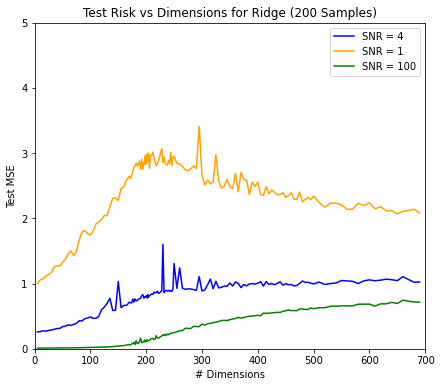

In [47]:
avgs1 = torch.mean(mse1, 1) #SNR 4 bc sigma 0.5
avgs2 = torch.mean(mse2, 1) #SNR 1 bc sigma 1
avgs3 = torch.mean(mse3, 1) #SNR 100 bs sigma 0.1


plt.figure(figsize=(7,6))
plt.title("Test Risk vs Dimensions for Ridge (200 Samples)")
plt.xlabel("# Dimensions")
plt.ylabel("Test MSE")
lw = 2
plt.ylim(0,5)
plt.xlim(0,700)
plt.plot(d_vals.cpu().numpy(), avgs1.cpu().numpy(),
         color='blue', label='SNR = 4')
plt.plot(d_vals.cpu().numpy(), avgs2.cpu().numpy(),
         color='orange', label='SNR = 1')
plt.plot(d_vals.cpu().numpy(), avgs3.cpu().numpy(),
         color='green', label='SNR = 100')

plt.xticks(torch.arange(0,701,step=100).cpu().numpy())
plt.plot()
plt.legend(loc="best")
plt.show()